In [21]:
import glob, pickle, cv2, glob, pickle
import numpy as np
import tracker
import matplotlib.pyplot as plt
%matplotlib inline

from moviepy.editor import VideoFileClip

In [22]:
import cv2
import numpy as np
from scipy import signal


def abs_sobel(img_ch, orient='x', sobel_kernel=3):
    """
    Applies the sobel operation on a gray scale image.

    :param img_ch:
    :param orient: 'x' or 'y'
    :param sobel_kernel: an uneven integer
    :return:
    """
    if orient == 'x':
        axis = (1, 0)
    elif orient == 'y':
        axis = (0, 1)
    else:
        raise ValueError('orient has to be "x" or "y" not "%s"' % orient)

    sobel = cv2.Sobel(img_ch, -1, *axis, ksize=sobel_kernel)
    abs_s = np.absolute(sobel)

    return abs_s


def gradient_magnitude(sobel_x, sobel_y):
    """
    Calculates the magnitude of the gradient.
    :param sobel_x:
    :param sobel_y:
    :return:
    """
    abs_grad_mag = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
    return abs_grad_mag.astype(np.uint16)


def gradient_direction(sobel_x, sobel_y):
    """
    Calculates the direction of the gradient. NaN values cause by zero division will be replaced
    by the maximum value (np.pi / 2).
    :param sobel_x:
    :param sobel_y:
    :return:
    """
    with np.errstate(divide='ignore', invalid='ignore'):
        abs_grad_dir = np.absolute(np.arctan(sobel_y / sobel_x))
        abs_grad_dir[np.isnan(abs_grad_dir)] = np.pi / 2

    return abs_grad_dir.astype(np.float32)


def gaussian_blur(img, kernel_size):
    """
    Applies a Gaussian Noise kernel
    :param img:
    :param kernel_size:
    :return:
    """
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def extract_yellow(img):
    """
    Generates an image mask selecting yellow pixels.
    :param img: image with pixels in range 0-255
    :return: Yellow 255 not yellow 0
    """
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, (20, 50, 150), (40, 255, 255))

    return mask


def extract_dark(img):
    """
    Generates an image mask selecting dark pixels.
    :param img: image with pixels in range 0-255
    :return: Dark 255 not dark 0
    """
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, (0, 0, 0.), (255, 153, 128))
    return mask


def extract_highlights(img, p=99.9):
    """
    Generates an image mask selecting highlights.
    :param p: percentile for highlight selection. default=99.9
    :param img: image with pixels in range 0-255
    :return: Highlight 255 not highlight 0
    """
    p = int(np.percentile(img, p) - 30)
    mask = cv2.inRange(img, p, 255)
    return mask


def binary_noise_reduction(img, thresh):
    """
    Reduces noise of a binary image by applying a filter which counts neighbours with a value
    and only keeping those which are above the threshold.
    :param img: binary image (0 or 1)
    :param thresh: min number of neighbours with value
    :return:
    """
    k = np.array([[1, 1, 1],
                  [1, 0, 1],
                  [1, 1, 1]])
    nb_neighbours = cv2.filter2D(img, ddepth=-1, kernel=k)
    img[nb_neighbours < thresh] = 0
    return img

def histogram_lane_detection(img, steps, search_window, h_window):
    """
    Tries to detect lane line pixels by applying a sliding histogram.
    :param img: binary image
    :param steps: steps for the sliding histogram
    :param search_window: Tuple which limits the horizontal search space.
    :param h_window: window size for horizontal histogram smoothing
    :return: x, y of detected pixels
    """
    all_x = []
    all_y = []
    masked_img = img[:, search_window[0]:search_window[1]]
    pixels_per_step = img.shape[0] // steps

    for i in range(steps):
        start = masked_img.shape[0] - (i * pixels_per_step)
        end = start - pixels_per_step
        histogram = np.sum(masked_img[end:start, :], axis=0)
        histogram_smooth = signal.medfilt(histogram, h_window)
        peaks = np.array(signal.find_peaks_cwt(histogram_smooth, np.arange(1, 5)))

        highest_peak = highest_n_peaks(histogram_smooth, peaks, n=1, threshold=5)
        if len(highest_peak) == 1:
            highest_peak = highest_peak[0]
            center = (start + end) // 2
            x, y = get_pixel_in_window(masked_img, highest_peak, center, pixels_per_step)

            all_x.extend(x)
            all_y.extend(y)

    all_x = np.array(all_x) + search_window[0]
    all_y = np.array(all_y)

    return all_x, all_y


def highest_n_peaks(histogram, peaks, n=2, threshold=0):
    """
    Returns the n highest peaks of a histogram above a given threshold.
    :param histogram:
    :param peaks: list of peak indexes
    :param n: number of peaks to select
    :param threshold:
    :return:
    """
    if len(peaks) == 0:
        return []

    peak_list = [(peak, histogram[peak]) for peak in peaks if histogram[peak] > threshold]
    peak_list = sorted(peak_list, key=lambda x: x[1], reverse=True)

    if len(peak_list) == 0:
        return []

    x, y = zip(*peak_list)
    x = list(x)

    if len(peak_list) < n:
        return x

    return x[:n]


def detect_lane_along_poly(img, poly, steps):
    """
    Slides a window along a polynomial an selects all pixels inside.
    :param img: binary image
    :param poly: polynomial to follow
    :param steps: number of steps for the sliding window
    :return: x, y of detected pixels
    """
    pixels_per_step = img.shape[0] // steps
    all_x = []
    all_y = []

    for i in range(steps):
        start = img.shape[0] - (i * pixels_per_step)
        end = start - pixels_per_step

        center = (start + end) // 2
        x = poly(center)

        x, y = get_pixel_in_window(img, x, center, pixels_per_step)

        all_x.extend(x)
        all_y.extend(y)

    return all_x, all_y


def get_pixel_in_window(img, x_center, y_center, size):
    """
    returns selected pixel inside a window.
    :param img: binary image
    :param x_center: x coordinate of the window center
    :param y_center: y coordinate of the window center
    :param size: size of the window in pixel
    :return: x, y of detected pixels
    """
    half_size = size // 2
    window = img[y_center - half_size:y_center + half_size, x_center - half_size:x_center + half_size]

    x, y = (window.T == 1).nonzero()

    x = x + x_center - half_size
    y = y + y_center - half_size

    return x, y


def calculate_lane_area(lanes, area_height, steps):
    """
    Returns a list of pixel coordinates marking the area between two lanes
    :param lanes: Tuple of Lines. Expects the line polynomials to be a function of y.
    :param area_height:
    :param steps:
    :return:
    """
    points_left = np.zeros((steps + 1, 2))
    points_right = np.zeros((steps + 1, 2))

    for i in range(steps + 1):
        pixels_per_step = area_height // steps
        start = area_height - i * pixels_per_step

        points_left[i] = [lanes[0].best_fit_poly(start), start]
        points_right[i] = [lanes[1].best_fit_poly(start), start]

    return np.concatenate((points_left, points_right[::-1]), axis=0)


def are_lanes_plausible(lane_one, lane_two, parallel_thresh=(0.0003, 0.55), dist_thresh=(350, 460)):
    """
    Checks if two lines are plausible lanes by comparing the curvature and distance.
    :param lane_one:
    :param lane_two:
    :param parallel_thresh: Tuple of float values representing the delta threshold for the
    first and second coefficient of the polynomials.
    :param dist_thresh: Tuple of integer values marking the lower and upper threshold
    for the distance between plausible lanes.
    :return:
    """
    is_parallel = lane_one.is_current_fit_parallel(lane_two, threshold=parallel_thresh)
    dist = lane_one.get_current_fit_distance(lane_two)
    is_plausible_dist = dist_thresh[0] < dist < dist_thresh[1]

    return is_parallel & is_plausible_dist


def draw_poly(img, poly, steps, color, thickness=10, dashed=False):
    """
    Draws a polynomial onto an image.
    :param img:
    :param poly:
    :param steps:
    :param color:
    :param thickness:
    :param dashed:
    :return:
    """
    img_height = img.shape[0]
    pixels_per_step = img_height // steps

    for i in range(steps):
        start = i * pixels_per_step
        end = start + pixels_per_step

        start_point = (int(poly(start)), start)
        end_point = (int(poly(end)), end)

        if dashed is False or i % 2 == 1:
            img = cv2.line(img, end_point, start_point, color, thickness)

    return img


def draw_poly_arr(img, poly, steps, color, thickness=10, dashed=False, tip_length=1):
    """
    Draws a polynomial onto an image using arrows.
    :param img:
    :param poly:
    :param steps:
    :param color:
    :param thickness:
    :param dashed:
    :param tip_length:
    :return:
    """
    img_height = img.shape[0]
    pixels_per_step = img_height // steps

    for i in range(steps):
        start = i * pixels_per_step
        end = start + pixels_per_step

        start_point = (int(poly(start)), start)
        end_point = (int(poly(end)), end)

        if dashed is False or i % 2 == 1:
            img = cv2.arrowedLine(img, end_point, start_point, color, thickness, tipLength=tip_length)

    return img


def outlier_removal(x, y, q=5):
    """
    Removes horizontal outliers based on a given percentile.
    :param x: x coordinates of pixels
    :param y: y coordinates of pixels
    :param q: percentile
    :return: cleaned coordinates (x, y)
    """
    if len(x) == 0 or len(y) == 0:
        return x, y

    x = np.array(x)
    y = np.array(y)

    lower_bound = np.percentile(x, q)
    upper_bound = np.percentile(x, 100 - q)
    selection = (x >= lower_bound) & (x <= upper_bound)
    return x[selection], y[selection]



In [23]:
ROWS, COLUMNS = 9, 6

def get_camera_calibration():
    # prepare object points and image points from images
    objp = np.zeros((COLUMNS*ROWS,3), np.float32)
    objp[:,:2] = np.mgrid[0:ROWS, 0:COLUMNS].T.reshape(-1, 2)

    objpoints = []
    imgpoints = []

    calibration_images = glob.glob('./camera_cal/calibration*.jpg')

    for index, filename in enumerate(calibration_images):
        img = cv2.imread(filename)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
        # find corners
        ret, corners = cv2.findChessboardCorners(gray, (ROWS,COLUMNS),None)
    
        # find object and image points
        if ret == True:
            #print("working on image: ", index)
            objpoints.append(objp)
            imgpoints.append(corners)
        
            #display corners
            cv2.drawChessboardCorners(img, (ROWS, COLUMNS), corners, ret)
            write_name = './output_images/corners_found'+str(index)+'.jpg'
            cv2.imwrite(write_name, img)
        

    img = cv2.imread('./camera_cal/calibration1.jpg')
    img_size = (img.shape[0], img.shape[1])

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    return objpoints, imgpoints, mtx, dist

In [24]:
class PerspectiveTransform:
    def __init__(self, src, dst):
        """
        Class transforming perspective
        """
        self.src = src
        self.dst = dst
        self.M = cv2.getPerspectiveTransform(src, dst)
        self.Minv = cv2.getPerspectiveTransform(dst, src)

    def warp(self, img):
        return cv2.warpPerspective(img, self.M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

    def inverse_warp(self, img):
        return cv2.warpPerspective(img, self.Minv, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    
    def undistort(self, img):
        return cv2.undistort(img, mtx, dist, None, mtx)
    
    def get_histogram(self, img):
        return np.sum(img[int(img.shape[0]/2):,:], axis=0)
    
    def generate_binary1(self, img):   
        v_cutoff=0
        window = img[v_cutoff:, :, :]
        yuv = cv2.cvtColor(window, cv2.COLOR_BGR2YUV)
        yuv = 255 - yuv
        hls = cv2.cvtColor(window, cv2.COLOR_BGR2HLS)
        chs = np.stack((yuv[:, :, 1], yuv[:, :, 2], hls[:, :, 2]), axis=2)
        gray = np.mean(chs, 2)

        s_x = abs_sobel(gray, orient='x', sobel_kernel=3)
        s_y = abs_sobel(gray, orient='y', sobel_kernel=3)

        grad_dir = gradient_direction(s_x, s_y)
        grad_mag = gradient_magnitude(s_x, s_y)

        ylw = extract_yellow(window)
        highlights = extract_highlights(window[:, :, 0])

        mask = np.zeros(img.shape[:-1], dtype=np.uint8)

        mask[v_cutoff:, :][((s_x >= 25) & (s_x <= 255) &
                        (s_y >= 25) & (s_y <= 255)) |
                       ((grad_mag >= 30) & (grad_mag <= 512) &
                        (grad_dir >= 0.2) & (grad_dir <= 1.)) |
                       (ylw == 255) |
                       (highlights == 255)] = 1

        mask = binary_noise_reduction(mask, 4)
        return mask
    
    def generate_binary2(self, img):
        ksize = 3
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        s_channel = hls[:,:,2]

        # Grayscale image
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Sobel x
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

        # Threshold x gradient
        thresh_min = 70
        thresh_max = 100
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

        # Threshold color channel
        s_thresh_min = 180
        s_thresh_max = 255
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

        # Stack each channel to view their individual contributions in green and blue respectively
        # This returns a stack of the two binary images, whose components you can see as different colors
        color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

        # Combine the two binary thresholds
        combined_binary = np.zeros_like(sxbinary)
        combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
        return combined_binary
        

In [25]:
objpoints, imgpoints, mtx, dist = get_camera_calibration()

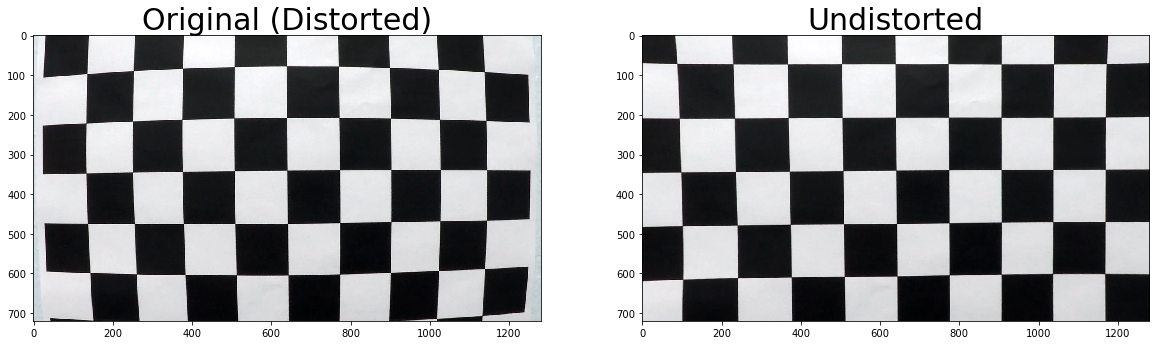

In [26]:
# plot distorted image
import matplotlib.pyplot as plt
%matplotlib inline

image = cv2.imread('./camera_cal/calibration1.jpg')

OFFSET = 150
SRC = np.float32([
    (132, 703),
    (540, 466),
    (740, 466),
    (1147, 703)])

DST = np.float32([
    (SRC[0][0] + OFFSET, 720),
    (SRC[0][0] + OFFSET, 0),
    (SRC[-1][0] - OFFSET, 0),
    (SRC[-1][0] - OFFSET, 720)])

transformer = PerspectiveTransform(SRC, DST)
undistorted = transformer.undistort(image)

    # Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title("Original (Distorted)", fontsize=30)
ax2.imshow(undistorted)
ax2.set_title('Undistorted', fontsize=30)

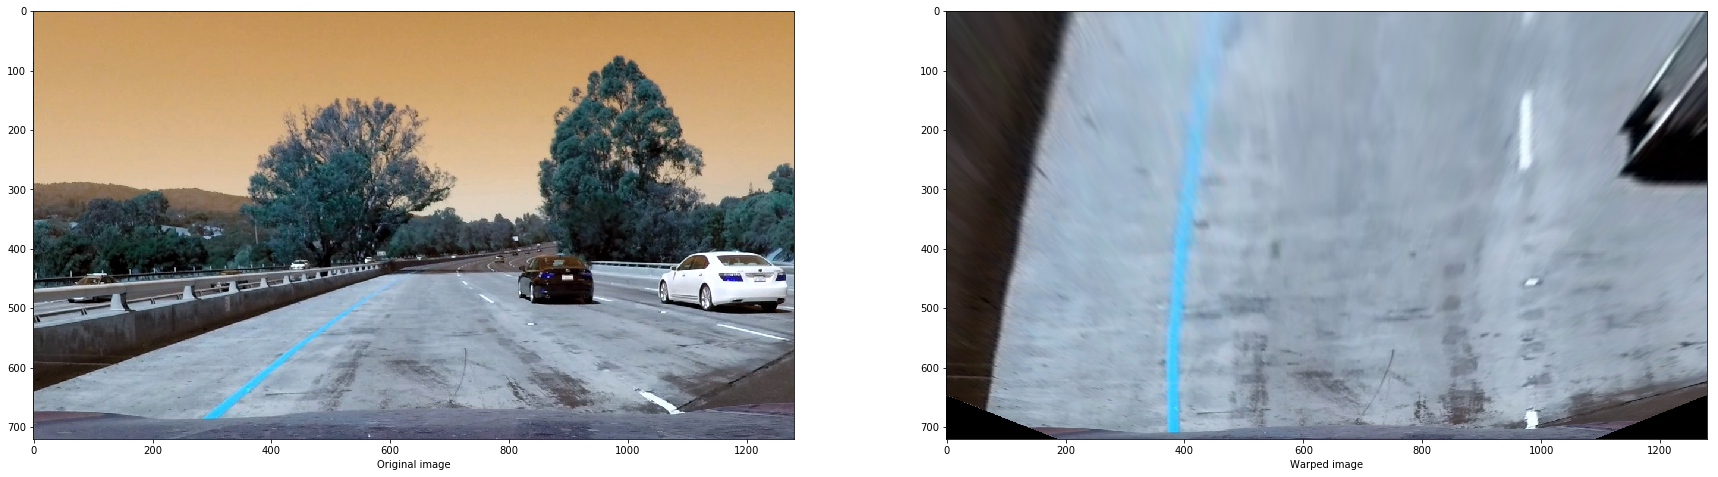

In [27]:
image = cv2.imread('./test_images/test1.jpg')
im2 = transformer.warp(image)

plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.hold(True)
plt.imshow(image)      
plt.xlabel('Original image')       
plt.subplot(1,2,2)
plt.hold(True)
plt.imshow(im2)       
plt.xlabel('Warped image')      
plt.show()

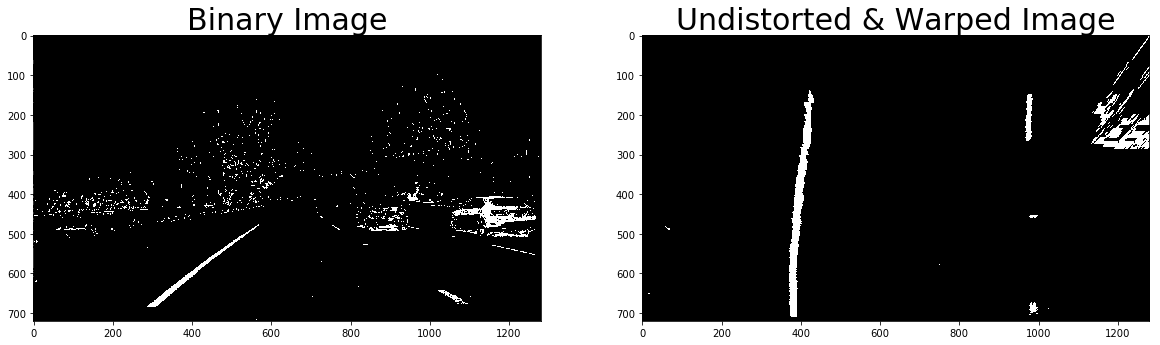

In [28]:
binary = transformer.generate_binary2(image)
warped = transformer.warp(binary)

for i in range(1):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))
    ax1.imshow(binary, cmap="gray")
    ax1.set_title("Binary Image", fontsize=30)
    ax2.imshow(warped, cmap="gray")
    ax2.set_title('Undistorted & Warped Image', fontsize=30)

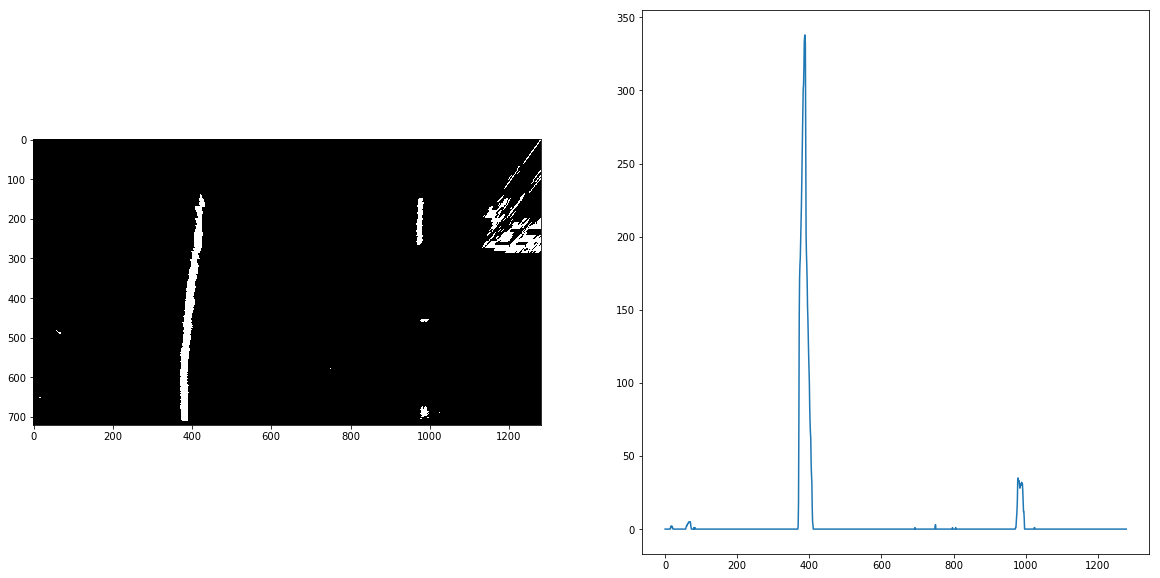

In [29]:

histogram = transformer.get_histogram(warped)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(warped, cmap="gray")
plt.plot(histogram)

In [30]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

class LaneDetector:
    def __init__(self, src, dst, n_frames=1, cam_calibration=None, line_segments=10,
                 transform_offset=0):

        self.n_frames = n_frames
        self.cam_calibration = cam_calibration
        self.line_segments = line_segments
        self.image_offset = transform_offset

        self.left_line = None
        self.right_line = None
        self.center_poly = None
        self.curvature = 0.0
        self.offset = 0.0

        self.perspective_src = src
        self.perspective_dst = dst
        self.perspective_transform = PerspectiveTransform(src, dst)

        self.dists = []
        
        # CONSTANTS
        self.margin = 100
        # Define conversions in x and y from pixels space to meters
        self.ym_per_pix = 30/720 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/700 # meters per pixel in x dimension
        
        ###
        self.img = None
        self.left_lane_inds = None
        self.right_lane_inds = None
        
        self.left_fitx = None
        self.right_fitx = None
        
        self.leftx = None
        self.lefty = None
        self.rightx = None
        self.righty = None
        
    def get_line_fit_sliding_windows(self, img):
        self.img = img
        # Get histogram
        histogram = np.sum(img[int(img.shape[0]/2):,:], axis=0)
        # Create an output image to draw on and  visualize the result
        self.out_img = np.dstack((img, img, img))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 20
        # Set height of windows
        window_height = np.int(img.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = img.shape[0] - (window+1)*window_height
            win_y_high = img.shape[0] - window*window_height
            win_xleft_low = leftx_current - self.margin
            win_xleft_high = leftx_current + self.margin
            win_xright_low = rightx_current - self.margin
            win_xright_high = rightx_current + self.margin
            # Draw the windows on the visualization image
            cv2.rectangle(self.out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(self.out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        self.left_fit = np.polyfit(lefty, leftx, 2)
        self.right_fit = np.polyfit(righty, rightx, 2)
        self.leftx = leftx
        self.lefty = lefty
        self.rightx = rightx
        self.righty = righty
        
    def get_line_fit(self, img):
        left_fit = self.left_fit
        right_fit = self.right_fit
        
        nonzero = img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - self.margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + self.margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - self.margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + self.margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        self.leftx = leftx
        self.lefty = lefty
        self.rightx = rightx
        self.righty = righty
        
    def curverad(self):
        # Define y-value where we want radius of curvature
        # I'll choose the maximum y-value, corresponding to the bottom of the image
        ym_per_pix = self.ym_per_pix
        xm_per_pix = self.xm_per_pix
        right_fit = self.right_fit
        leftx = self.leftx
        lefty = self.lefty
        rightx = self.rightx
        righty = self.righty
        
        ploty = np.linspace(0, self.img.shape[0]-1, self.img.shape[0])
        y_eval = np.max(ploty)
    
        # Fit new polynomials to x,y in world space
        a=ploty*ym_per_pix
        b=leftx*xm_per_pix

        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radius of curvature
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        return left_curverad, right_curverad
    
    def get_params(self):
        img = self.img
        left_fit = self.left_fit
        right_fit = self.right_fit
        # Generate x and y values for plotting
        ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        return ploty, left_fitx, right_fitx
    
    def plot(self):
        img = self.img
        left_fit = self.left_fit
        right_fit = self.right_fit   
        
        out_img = np.dstack((self.img, self.img, self.img))*255
        window_img = np.zeros_like(out_img)
        
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        ploty, left_fitx, right_fitx = self.get_params()

        out_img[nonzeroy[self.left_lane_inds], nonzerox[self.left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[self.right_lane_inds], nonzerox[self.right_lane_inds]] = [0, 0, 255]
        plt.imshow(self.out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, out_img.shape[1])
        plt.ylim(out_img.shape[0], 0)
        
    def plot_polynomial_curve(self):
        img = self.img        
        left_fit = self.left_fit
        right_fit = self.right_fit
        
        out_img = np.dstack((self.img, self.img, self.img))*255
        window_img = np.zeros_like(out_img)
        ploty, left_fitx, right_fitx = self.get_params()

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-self.margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+self.margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-self.margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+self.margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))
        
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, out_img.shape[1])
        plt.ylim(out_img.shape[0], 0)
        

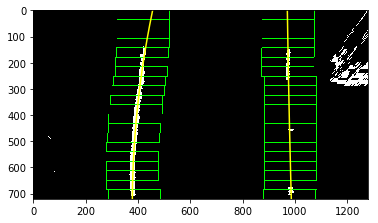

In [31]:
ld = LaneDetector(SRC, DST)
ld.get_line_fit_sliding_windows(warped)
ld.plot()

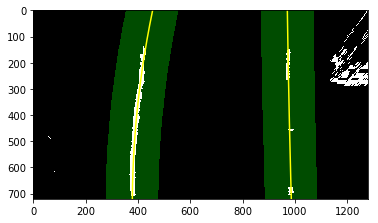

In [32]:
ld.get_line_fit(warped)
ld.plot_polynomial_curve()

In [33]:
image = cv2.imread('./test_images/test2.jpg')
binary = transformer.generate_binary2(image)
warped = transformer.warp(binary)
ld.get_line_fit_sliding_windows(warped)

lr, rr = ld.curverad()
print("Radii: ", lr, rr)

Radii:  1359.3478905 1516.27543456


In [44]:
class ProcessImage:
    def __init__(self):

        self.OFFSET = 250
        self.SRC = np.float32([ (132, 703),
                                (540, 466),
                                (740, 466),
                                (1147, 703)])

        self.DST = np.float32([ (SRC[0][0] + OFFSET, 720),
                                (SRC[0][0] + OFFSET, 0),
                                (SRC[-1][0] - OFFSET, 0),
                                (SRC[-1][0] - OFFSET, 720)])
        self.transformer = PerspectiveTransform(self.SRC, self.DST)
    
    def process_image(self, img):
        undistorted = transformer.undistort(img)
        binary = transformer.generate_binary1(undistorted)
        warped = transformer.warp(binary)

        ld = LaneDetector(self.SRC, self.DST)
        ld.get_line_fit_sliding_windows(warped)
        ld.get_line_fit(warped)

        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        ploty, left_fitx, right_fitx = ld.get_params()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = self.transformer.inverse_warp(color_warp) #cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
        # Combine the result with the original image

        return cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
        

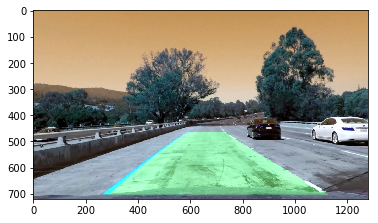

In [45]:
image = cv2.imread('./test_images/test1.jpg')
processor = ProcessImage()
result = processor.process_image(image)
plt.imshow(result)

In [46]:
#clear_cache()
vid_output = 'project_video_out.mp4'
clip = VideoFileClip('project_video.mp4')
vid_clip = clip.fl_image(processor.process_image)
%time vid_clip.write_videofile(vid_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [03:18<00:00,  5.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 11min 10s, sys: 11.5 s, total: 11min 21s
Wall time: 3min 19s


In [47]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('project_video_out.mp4'))